Original shape: (9310, 33)
Shape after outlier removal: (9183, 24087)


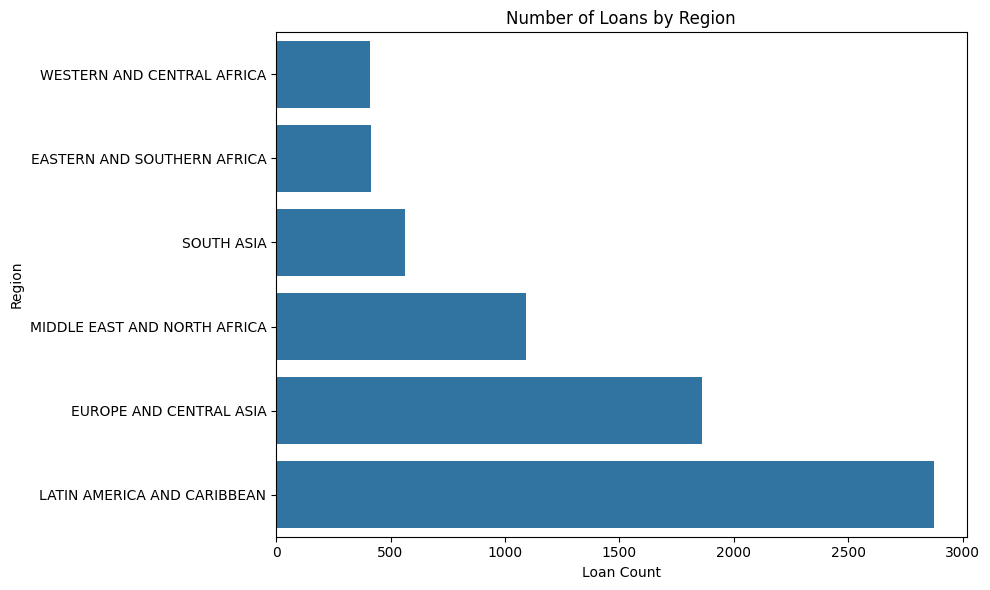

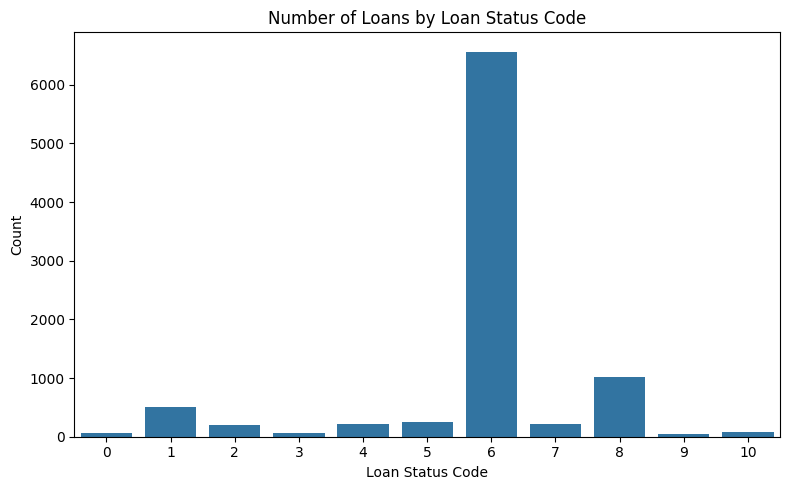


📌 Training: Random Forest
Random Forest training time: 1.80 seconds
Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      1.00      1.00       135
           2       1.00      1.00      1.00        44
           3       1.00      1.00      1.00        13
           4       1.00      1.00      1.00        57
           5       1.00      1.00      1.00        68
           6       1.00      1.00      1.00      1621
           7       1.00      1.00      1.00        59
           8       1.00      1.00      1.00       256
           9       1.00      1.00      1.00        11
          10       1.00      1.00      1.00        17

    accuracy                           1.00      2296
   macro avg       1.00      1.00      1.00      2296
weighted avg       1.00      1.00      1.00      2296

Confusion Matrix:
 [[  15    0    0    0    0    0    0    0    0    0    0]
 [ 

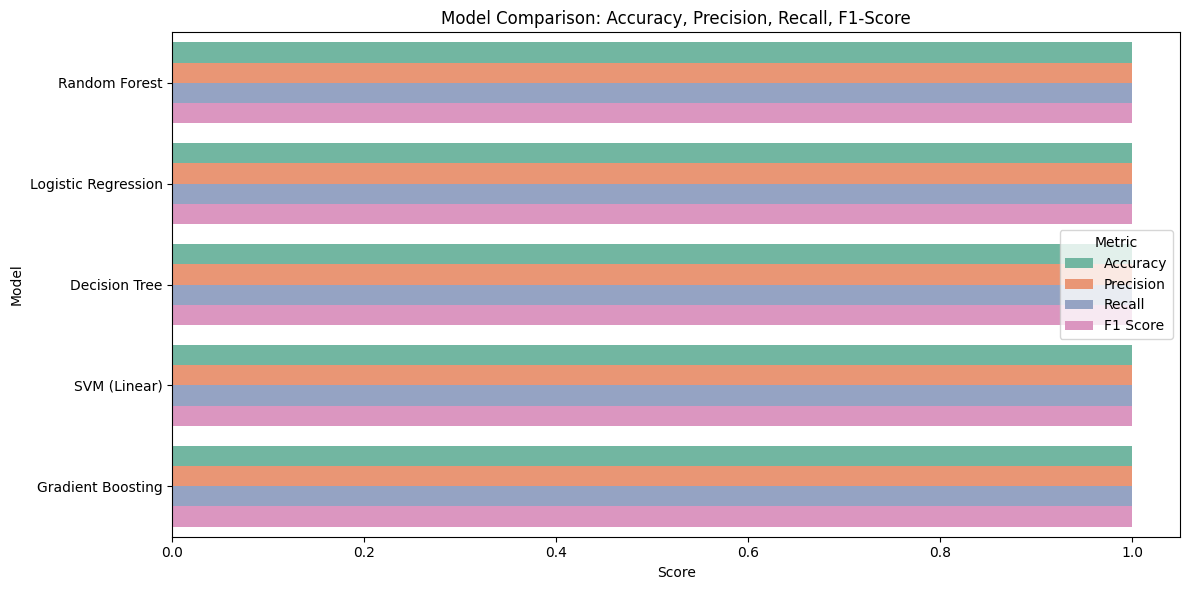

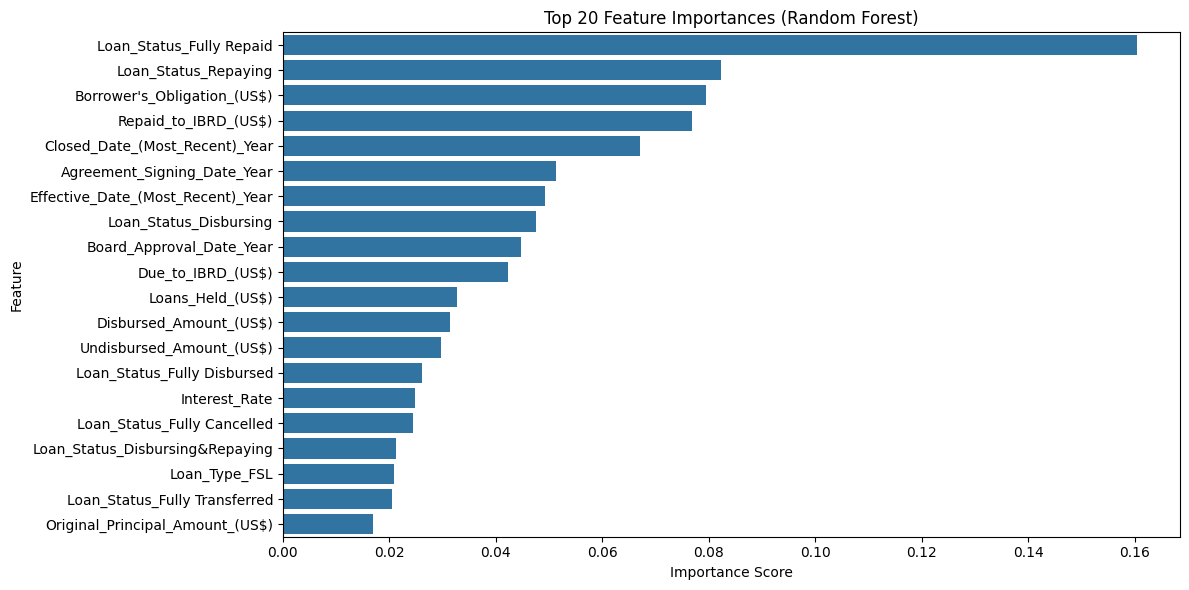

In [ ]:
# Step 1: Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest, f_classif
from scipy.stats import zscore
import warnings
warnings.filterwarnings('ignore')

# Step 2: Load Dataset
df = pd.read_csv(r'C:\Users\praso\Downloads\ibrd_statement_of_loans_and_guarantees_latest_available_snapshot_06-27-2025.csv')
print("Original shape:", df.shape)

# Step 3: Clean Column Names
df.columns = df.columns.str.strip().str.replace(' ', '_').str.replace('/', '_')

# Step 4: Drop Columns with >50% Missing
threshold = len(df) * 0.5
df = df.loc[:, df.isnull().sum() < threshold]

# Step 5: Fill Remaining Numeric NaNs with Mean
num_cols = df.select_dtypes(include=[np.number]).columns
df[num_cols] = df[num_cols].fillna(df[num_cols].mean())

# Step 6: Drop Duplicates
df.drop_duplicates(inplace=True)

# Step 7: Convert Date Columns
date_cols = ['First_Repayment_Date', 'Last_Repayment_Date', 'Agreement_Signing_Date',
             'Board_Approval_Date', 'Effective_Date_(Most_Recent)', 'Closed_Date_(Most_Recent)',
             'Last_Disbursement_Date', 'End_of_Period']
for col in date_cols:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')

# Step 8: Feature Engineering from Dates
if 'Agreement_Signing_Date' in df.columns and 'Closed_Date_(Most_Recent)' in df.columns:
    df['Loan_Duration_Days'] = (df['Closed_Date_(Most_Recent)'] - df['Agreement_Signing_Date']).dt.days

for col in ['Agreement_Signing_Date', 'Board_Approval_Date', 'Effective_Date_(Most_Recent)',
            'Closed_Date_(Most_Recent)', 'End_of_Period']:
    if col in df.columns:
        df[col + '_Year'] = df[col].dt.year
        df[col + '_Month'] = df[col].dt.month

df.drop(columns=date_cols, inplace=True, errors='ignore')

# Step 9: Encode Target Variable
if 'Loan_Status' in df.columns:
    df['Loan_Status_Code'] = df['Loan_Status'].astype('category').cat.codes

# Step 10: One-Hot Encode Categorical Features
cat_cols = df.select_dtypes(include=['object']).columns
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# Step 11: Outlier Detection (Z-Score)
num_cols = df.select_dtypes(include=[np.number]).columns
z_scores = np.abs(zscore(df[num_cols]))
df = df[(z_scores < 3).sum(axis=1) >= (len(num_cols) // 2)]
print("Shape after outlier removal:", df.shape)

# Step 12: Scaling Numerical Columns
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if 'Loan_Status_Code' in num_cols:
    num_cols.remove('Loan_Status_Code')
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

# Step 13: Visualizations
region_cols = [col for col in df.columns if col.startswith('Region_')]
if region_cols:
    region_counts = df[region_cols].sum().sort_values()
    plt.figure(figsize=(10, 6))
    sns.barplot(x=region_counts.values, y=region_counts.index.str.replace('Region_', ''))
    plt.title('Number of Loans by Region')
    plt.xlabel('Loan Count')
    plt.ylabel('Region')
    plt.tight_layout()
    plt.show()

if 'Loan_Status_Code' in df.columns:
    plt.figure(figsize=(8, 5))
    sns.countplot(x='Loan_Status_Code', data=df)
    plt.title('Number of Loans by Loan Status Code')
    plt.xlabel('Loan Status Code')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

# Step 14: Prepare Data for Modeling
drop_cols = ['Loan_Status', 'Loan_Number', 'Country__Economy', 'Borrower', 'Guarantor',
             'Region', 'Country__Economy_Code', 'Guarantor_Country__Economy_Code']
safe_drop_cols = [col for col in drop_cols if col in df.columns]
X = df.drop(columns=safe_drop_cols + ['Loan_Status_Code'], errors='ignore')
y = df['Loan_Status_Code']
X = X.fillna(0)

# Step 15: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Step 16: Train and Evaluate Models
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(max_depth=10, min_samples_split=10, random_state=42),
    "SVM (Linear)": SVC(kernel='linear', random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}

metrics = {"Model": [], "Accuracy": [], "Precision": [], "Recall": [], "F1 Score": []}

for name, model in models.items():
    print(f"\n📌 Training: {name}")
    start = time.time()
    model.fit(X_train, y_train)
    end = time.time()
    y_pred = model.predict(X_test)
    print(f"{name} training time: {end - start:.2f} seconds")
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    print("Accuracy:", acc)
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    metrics["Model"].append(name)
    metrics["Accuracy"].append(acc)
    metrics["Precision"].append(prec)
    metrics["Recall"].append(rec)
    metrics["F1 Score"].append(f1)

# Step 17: Grouped Bar Plot for Model Metrics
metrics_df = pd.DataFrame(metrics)
metrics_melted = metrics_df.melt(id_vars='Model', var_name='Metric', value_name='Score')
plt.figure(figsize=(12, 6))
sns.barplot(x='Score', y='Model', hue='Metric', data=metrics_melted, palette='Set2')
plt.title("Model Comparison: Accuracy, Precision, Recall, F1-Score")
plt.xlabel("Score")
plt.ylabel("Model")
plt.legend(title='Metric')
plt.tight_layout()
plt.show()

# Step 18: Feature Importance (Random Forest Only)
rf_model = models['Random Forest']
importances = rf_model.feature_importances_
features = X.columns
sorted_indices = np.argsort(importances)[::-1]
plt.figure(figsize=(12, 6))
sns.barplot(x=importances[sorted_indices][:20], y=features[sorted_indices][:20])
plt.title("Top 20 Feature Importances (Random Forest)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()
